In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

# index data
tokens = sorted(list(set(''.join(words))))
stoi = {x:i+1 for i,x in enumerate(tokens)}
stoi['.'] = 0
itos = {i:x for x,i in stoi.items()}

vocab_size = len(stoi)

In [3]:
# build the dataset

BLOCK_SIZE = 3 # how many characters to use to predict next character?
def build_dataset(words):
  X = []
  Y = []

  for word in words:
    # print(word)
    ctx = [0] * BLOCK_SIZE
    for c in word + '.':
      y = stoi[c]
      X.append(ctx)
      Y.append(y)
      # print(''.join(itos[i] for i in ctx), ' -> ', itos[y])
      ctx = ctx[1:] + [y]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [44]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embed = 10 # character embedding dimenstions
n_hidden = 100 # num of neurons in the hidden layer
g = torch.Generator().manual_seed(12121212) # for repreducibility

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * BLOCK_SIZE, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

params = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in params)) # num of params in network
for p in params:
    p.requires_grad = True

47551


In [1]:
torch.device('mps')

NameError: name 'torch' is not defined

In [45]:
# optimization
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # build mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # characters for ix as feature vector
    x = emb.view(emb.shape[0], -1) # concatenation of last dim ---> BLOCK_SIZE * n_embed
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # nll loss
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in params:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # learning rate decay
    for p in params:
        p.data += -lr * p.grad
    
    # stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in params])
    if i > 1000:
        break # AFTER_DEBUG: remove obv to run full optimization

      0/ 200000: 3.3015


layer 2 (      Tanh): mean +0.00, std: +0.64, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std: +0.64, saturated: 2.25%
layer 8 (      Tanh): mean -0.01, std: +0.65, saturated: 1.88%
layer 11 (      Tanh): mean -0.00, std: +0.65, saturated: 2.31%
layer 14 (      Tanh): mean -0.00, std: +0.65, saturated: 1.94%


Text(0.5, 1.0, 'activation distribution')

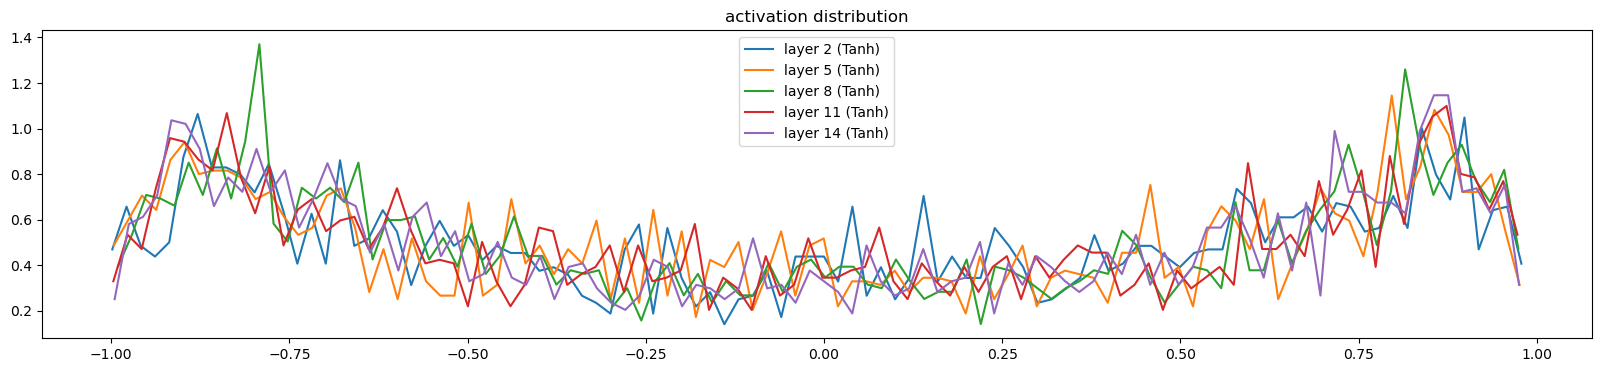

In [46]:
# vis histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std: %+.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.00, std: +0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std: +0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std: +0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std: +0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std: +0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

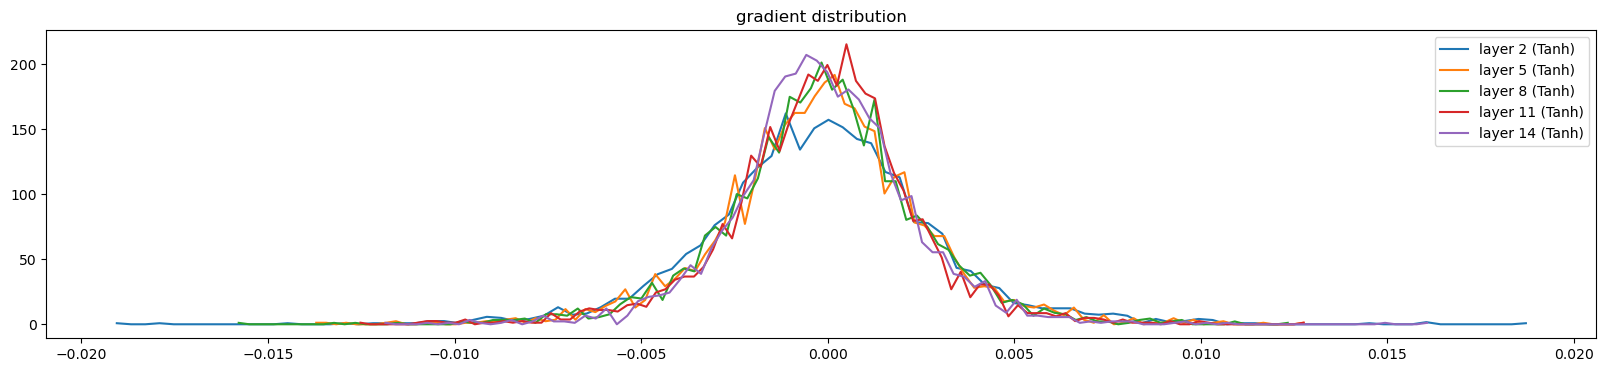

In [47]:
# vis gradient
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std: %+.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 7.001548e-03 | grad:data ratio 7.164171e-03
weight  (30, 100) | mean -0.000044 | std 6.320012e-03 | grad:data ratio 2.096808e-02
weight (100, 100) | mean -0.000001 | std 5.265998e-03 | grad:data ratio 3.150700e-02
weight (100, 100) | mean +0.000017 | std 4.753980e-03 | grad:data ratio 2.878490e-02
weight (100, 100) | mean +0.000009 | std 4.653626e-03 | grad:data ratio 2.746389e-02
weight (100, 100) | mean -0.000021 | std 3.960970e-03 | grad:data ratio 2.357169e-02
weight  (100, 27) | mean -0.000254 | std 8.001489e-03 | grad:data ratio 4.905303e-02


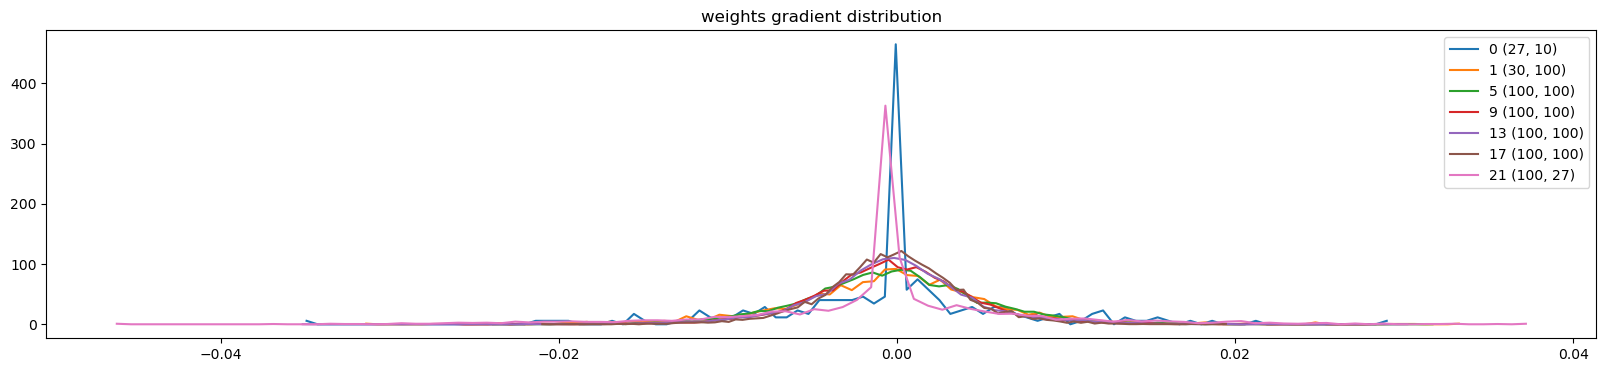

In [48]:
# vis params
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(params):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

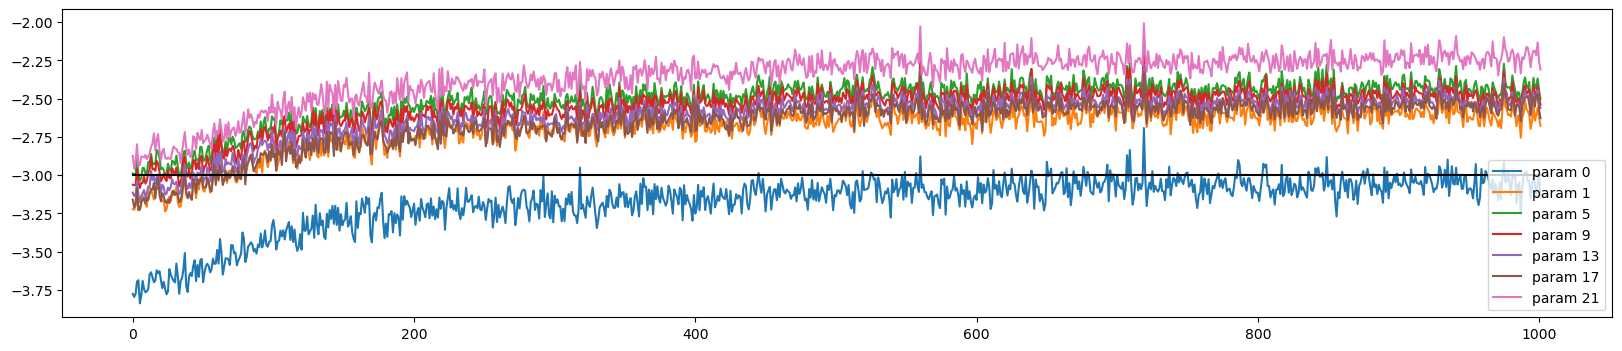

In [49]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(params):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # should be ~1e-3
plt.legend(legends)